# Exercise 8

Anomaly Detection and Collaborative Filtering

In [1]:
import io
import matplotlib.pyplot as plt

import numpy as np
from numpy import linalg

from scipy.io import loadmat
from scipy.optimize import minimize

## Part 1: Loading movie ratings dataset

You will start by loading the movie ratings dataset to understand the
structure of the data.

In [2]:
data = loadmat('ex8_movies.mat')

# Ratings of movies
Y = data['Y']
print(Y.shape)

# R[i, j] = 1, indicating user j gave a rating to movie i.
R = data['R']
print(R.shape)

(1682, 943)
(1682, 943)


In [3]:
#  From the matrix, we can compute statistics like average rating.
print(f'Average rating for movie 1 (Toy Story): {np.mean(Y[1, R[1, :]]):2.3} / 5')

Average rating for movie 1 (Toy Story): 2.58 / 5


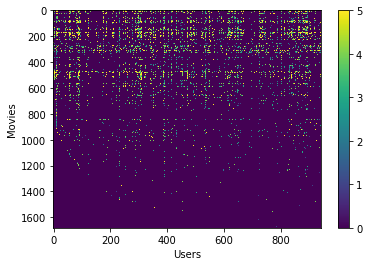

In [4]:
# We can "visualize" the ratings matrix by plotting it with imagesc.
plt.imshow(Y, aspect='auto');
plt.colorbar();
plt.ylabel('Movies');
plt.xlabel('Users');

## Part 2: Collaborative Filtering Cost Function

You will now implement the cost function for collaborative
filtering. To help you debug your cost function, we have included set
of weights that we trained on that. Specifically, you should complete
the code in cofiCostFunc.m to return J.

In [5]:
# Load pre-trained weights (X, Theta, num_users, num_movies, num_features).
data = loadmat('ex8_movieParams.mat')

X = data['X']
Theta = data['Theta']
num_users = data['num_users']
num_movies = data['num_movies']
num_features = data['num_features']

In [6]:
# Reduce the data set size so that this runs faster.

num_users = 4
num_movies = 5
num_features = 3
X = X[:num_movies, :num_features]
Theta = Theta[:num_users, : num_features]
Y = Y[:num_movies, :num_users]
R = R[:num_movies, :num_users]

In [7]:
def cofi_cost_func(params, Y, R, num_users, num_movies, num_features, lambda_):
    '''Returns the cost and gradient fo rthe collaborative filtering problem.'''

    X = params[:(num_movies * num_features)].reshape((num_movies, num_features))
    Theta = params[(num_movies * num_features):].reshape((num_users, num_features))
    
    tmp = (np.dot(X, Theta.T) - Y) * R
    J = np.sum(tmp ** 2) / 2 + lambda_ * .5 * np.sum(X ** 2) + lambda_ * .5 * np.sum(Theta ** 2)
    
    X_grad = np.dot(tmp, Theta) + lambda_ * X
    Theta_grad = np.dot(tmp.T, X) + lambda_ * Theta
    
    grad = np.concatenate((X_grad.reshape(-1), Theta_grad.reshape(-1)))
    
    return J, grad

In [8]:
J, _ = cofi_cost_func(np.concatenate((X.reshape(-1), Theta.reshape(-1))), Y, R, num_users, num_movies, num_features, 0)

print(f'''Cost at loaded parameters: {J:5.3f}
(this value should be about 22.22)''')

Cost at loaded parameters: 22.225
(this value should be about 22.22)


# Part 3: Collaborative Filtering Gradient

Once your cost function matches up with ours, you should now implement
the collaborative filtering gradient function. Specifically, you
should complete the code in cofiCostFunc.m to return the grad
argument.

In [9]:
def compute_numberical_gradient(J, theta):
    '''Computes the gradient using "finite differences" and gives us a numerical estimate of the gradient.'''
    
    numgrad = np.zeros_like(theta)
    perturb = np.zeros_like(theta)
    e = 1e-4
    for p in range(theta.size):
        perturb[p] = e
        loss1, _ = J(theta - perturb)
        loss2, _ = J(theta + perturb)
        
        numgrad[p] = (loss2 - loss1) / (2 * e)
        perturb[p] = 0
        
    return numgrad

def check_cost_function(lambda_=None):
    '''Creates a collaborative filering problem to check your cost function
and gradients, it will output the analytical gradients produced by
your code and the numerical gradients (computed using
computeNumericalGradient). These two gradient computations should
result in very similar values.
    '''
    
    if lambda_ is None:
        lambda_ = 0
    
    # Create a small problem
    X_t = np.random.rand(4, 3)
    Theta_t = np.random.rand(5, 3)
    
    # Zap out most entries
    Y = np.dot(X_t, Theta_t.T)
    Y[np.random.rand(*Y.shape) > .5] = 0
    R = np.zeros_like(Y)
    R[Y != 0] = 1
    
    # Run Gradient Checking
    X = np.random.randn(*X_t.shape)
    Theta = np.random.randn(*Theta_t.shape)
    num_movies, num_users = Y.shape
    num_features = Theta_t.shape[1]
    
    numgrad = compute_numberical_gradient(
        lambda t: cofi_cost_func(t, Y, R, num_users, num_movies, num_features, lambda_),
        np.concatenate((X.reshape(-1), Theta.reshape(-1)))
    )
    
    cost, grad = cofi_cost_func(np.concatenate((X.reshape(-1), Theta.reshape(-1))), Y, R, num_users, num_movies, num_features, lambda_)
    print(f'''{numgrad}
{grad}
The above two columns you get should be very similar.
(Left-Your Numerical Gradient, Right-Analytical Gradient)
''')
    
    diff = linalg.norm(numgrad - grad) / linalg.norm(numgrad + grad)
    print(f'''If your backpropagation implementation is correct, then the relative
difference will be small (less than 1e-9).
Relative Difference: {diff:2.5}''')

In [10]:
# Check gradients.
check_cost_function()

[-0.54706025  1.34755638 -1.91316978 -0.99264258  0.21116674 -1.25686937
 -0.28787058  2.50315145 -2.68647009 -0.04751976  0.49462186  1.98494842
  0.          0.          0.          0.          0.          0.
  2.52419066 -1.57998713 -3.68580477  1.15899839 -1.00274487 -2.00998836
  0.2082124  -6.02193636  0.10132414]
[-0.54706025  1.34755638 -1.91316978 -0.99264258  0.21116674 -1.25686937
 -0.28787058  2.50315145 -2.68647009 -0.04751976  0.49462186  1.98494842
  0.          0.          0.          0.          0.          0.
  2.52419066 -1.57998713 -3.68580477  1.15899839 -1.00274487 -2.00998836
  0.2082124  -6.02193636  0.10132414]
The above two columns you get should be very similar.
(Left-Your Numerical Gradient, Right-Analytical Gradient)

If your backpropagation implementation is correct, then the relative
difference will be small (less than 1e-9).
Relative Difference: 1.3383e-12


## Part 4: Collaborative Filtering Cost Regularization

Now, you should implement regularization for the cost function for
collaborative filtering. You can implement it by adding the cost of
regularization to the original cost computation.

In [11]:
# Evaluate cost function

J, _ = cofi_cost_func(np.concatenate((X.reshape(-1), Theta.reshape(-1))), Y, R, num_users, num_movies, num_features, 1.5)
print(f'''Cost at loaded parameters (lambda = 1.5): {J:5.3f}
(this value should be about 31.34)''')

Cost at loaded parameters (lambda = 1.5): 31.344
(this value should be about 31.34)


## Part 5: Collaborative Filtering Gradient Regularization

Once your cost matches up with ours, you should proceed to implement
regularization for the gradient.

In [12]:
# Check gradients.
check_cost_function(1.5)

[ -4.89820437  13.32287437 -13.23574154  -1.65418322  -1.47605642
   0.76727706 -17.17136005   4.41879819  -3.09992773 -12.70301165
   1.11250438  -3.92710617   6.19797696  -7.72755254   1.88299585
  -3.00999353  10.80148438 -11.45972637   1.3783181   -5.11161406
   4.72206754  -3.68592393  -0.3246196   -2.69797665  10.13149997
  -6.03066782   3.16670173]
[ -4.89820437  13.32287437 -13.23574154  -1.65418322  -1.47605642
   0.76727706 -17.17136005   4.41879819  -3.09992773 -12.70301165
   1.11250438  -3.92710617   6.19797696  -7.72755254   1.88299585
  -3.00999353  10.80148438 -11.45972637   1.3783181   -5.11161406
   4.72206754  -3.68592393  -0.3246196   -2.69797665  10.13149997
  -6.03066782   3.16670173]
The above two columns you get should be very similar.
(Left-Your Numerical Gradient, Right-Analytical Gradient)

If your backpropagation implementation is correct, then the relative
difference will be small (less than 1e-9).
Relative Difference: 2.0655e-12


## Part 6: Entering ratings for a new user

Before we will train the collaborative filtering model, we will first
add ratings that correspond to a new user that we just observed. This
part of the code will also allow you to put in your own ratings for
the movies in our dataset!

In [13]:
def load_movie_list():
    with io.open('movie_ids.txt', mode='r', encoding='utf-8') as f:
        return [l.split(' ', maxsplit=1)[1].strip() for l in f.readlines()]

In [14]:
movie_list = load_movie_list()

In [15]:
# Initializing my ratings.
my_ratings = np.zeros((1682, 1))

# Check the file movie_idx.txt for id of each movie in our dataset
# For example, Toy Story (1995) has ID 1, so to rate it "4", you can set
my_ratings[0] = 4

# Or suppose did not enjoy Silence of the Lambs (1991), you can set
my_ratings[97] = 2

# We have selected a few movies we liked / did not like and the ratings we gave are as follows:
my_ratings[6] = 3
my_ratings[11] = 5
my_ratings[53] = 4
my_ratings[63] = 5
my_ratings[65] = 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

print('New user ratings:\n')
for i in range(my_ratings.size):
    if my_ratings[i] > 0:
        print(f'Rated {my_ratings[i][0]} for {movie_list[i]}')

New user ratings:

Rated 4.0 for Toy Story (1995)
Rated 3.0 for Twelve Monkeys (1995)
Rated 5.0 for Usual Suspects, The (1995)
Rated 4.0 for Outbreak (1995)
Rated 5.0 for Shawshank Redemption, The (1994)
Rated 3.0 for While You Were Sleeping (1995)
Rated 5.0 for Forrest Gump (1994)
Rated 2.0 for Silence of the Lambs, The (1991)
Rated 4.0 for Alien (1979)
Rated 5.0 for Die Hard 2 (1990)
Rated 5.0 for Sphere (1998)


# Part 7: Learning Movie Ratings

Now, you will train the collaborative filtering model on a movie
rating dataset of 1682 movies and 943 users.

In [16]:
def normalize_ratings(Y, R):
    '''Normalize Y so that each movie has a rating of 0 on average, and returns the mean rating in Y_mean.'''

    m, n = Y.shape
    Y_mean = np.zeros((m, 1))
    Y_norm = np.zeros_like(Y)

    for i in range(m):
        idx = np.where(R[i, :] == 1)[0]
        Y_mean[i] = np.mean(Y[i, idx])
        Y_norm[i, idx] = Y[i, idx] - Y_mean[i]

    return Y_norm, Y_mean

In [17]:
data = loadmat('ex8_movies.mat')
Y = data['Y']
R = data['R']

In [18]:
Y = np.hstack((my_ratings, Y))
R = np.hstack((my_ratings != 0, R))

In [19]:
# Normalize ratings.

Y_norm, Y_mean = normalize_ratings(Y, R)

In [20]:
# Useful values.
num_movies, num_users = Y.shape
num_features = 10

# Set initial parameters
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)
initial_parameters = np.concatenate((X.reshape(-1), Theta.reshape(-1)))

# Set regularization
lambda_ = 10

In [21]:
theta = minimize(lambda t: cofi_cost_func(t, Y, R, num_users, num_movies, num_features, lambda_), initial_parameters, method='CG', jac=True, options={'maxiter': 100}).x

In [22]:
X = theta[:(num_movies * num_features)].reshape((num_movies, num_features))
Theta = theta[(num_movies * num_features):].reshape((num_users, num_features))

## Part 8: Recommendation for you

After training the model, you can now make recommendations by
computing the predictions matrix.

In [23]:
p = np.dot(X, Theta.T)
my_predictions = p[:, 0] + Y_mean[:, 0]

In [24]:
ix = np.argsort(my_predictions)[::-1]
print('Top recommendations for you:\n')
for i in range(10):
    j = ix[i]
    print(f'Predicting rating {my_predictions[j]:4.2f} for movie {movie_list[j]}')

Top recommendations for you:

Predicting rating 8.55 for movie Star Wars (1977)
Predicting rating 8.45 for movie Titanic (1997)
Predicting rating 8.41 for movie Shawshank Redemption, The (1994)
Predicting rating 8.27 for movie Raiders of the Lost Ark (1981)
Predicting rating 8.26 for movie Schindler's List (1993)
Predicting rating 8.11 for movie Good Will Hunting (1997)
Predicting rating 8.11 for movie Empire Strikes Back, The (1980)
Predicting rating 8.10 for movie Usual Suspects, The (1995)
Predicting rating 8.09 for movie Braveheart (1995)
Predicting rating 8.06 for movie Godfather, The (1972)


In [25]:
print('Original ratings provides:\n')
for i in range(my_ratings.size):
    if my_ratings[i] > 0:
        print(f'Rated {my_ratings[i][0]} for {movie_list[i]}')

Original ratings provides:

Rated 4.0 for Toy Story (1995)
Rated 3.0 for Twelve Monkeys (1995)
Rated 5.0 for Usual Suspects, The (1995)
Rated 4.0 for Outbreak (1995)
Rated 5.0 for Shawshank Redemption, The (1994)
Rated 3.0 for While You Were Sleeping (1995)
Rated 5.0 for Forrest Gump (1994)
Rated 2.0 for Silence of the Lambs, The (1991)
Rated 4.0 for Alien (1979)
Rated 5.0 for Die Hard 2 (1990)
Rated 5.0 for Sphere (1998)
